In [27]:
%pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.7/127.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [65]:
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
import math

In [37]:
data_dir = Path("/Users/anviththumma/Desktop/School/DAT 490/filtered_years/")

csv_files = [
    data_dir / "Medicare_FFS_2020_filtered.csv",
    data_dir / "Medicare_FFS_2021_filtered.csv",
    data_dir / "Medicare_FFS_2022_filtered.csv",
    data_dir / "Medicare_FFS_2018_filtered.csv",
    data_dir / "Medicare_FFS_2019_filtered.csv",
    data_dir / "Medicare_FFS_2021_filtered.csv",
]

In [38]:
lazy_2018 = pl.scan_csv(data_dir / "Medicare_FFS_2018_filtered.csv")
lazy_2019 = pl.scan_csv(data_dir / "Medicare_FFS_2019_filtered.csv")
lazy_2020 = pl.scan_csv(data_dir / "Medicare_FFS_2020_filtered.csv")
lazy_2022 = pl.scan_csv(data_dir / "Medicare_FFS_2022_filtered.csv")
lazy_2021 = pl.scan_csv(data_dir / "Medicare_FFS_2021_filtered.csv")

In [39]:
df_2018 = lazy_2018.collect()
df_2019 = lazy_2019.collect()
df_2020 = lazy_2020.collect()
df_2022 = lazy_2022.collect()
df_2021 = lazy_2021.collect()

In [40]:
df_2018_state = df_2018.filter(pl.col("geographiclevel") == "State")
df_2019_state = df_2019.filter(pl.col("geographiclevel") == "State")
df_2020_state = df_2020.filter(pl.col("geographiclevel") == "State")
df_2022_state = df_2022.filter(pl.col("geographiclevel") == "State")
df_2021_state = df_2021.filter(pl.col("geographiclevel") == "State")

In [16]:
df_2018_state.head(5)

yearstart,yearend,locationabbr,locationdesc,geographiclevel,topic,category,question,response,age,sex,raceethnicity,riskfactor,riskfactorresponse,data_value,data_value_type,data_value_unit,low_confidence_limit,high_confidence_limit,numerator,sample_size
i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,f64,f64,str,str
2018,2018,"""TX""","""Texas""","""State""","""Eye Health Conditions""","""Cornea Disorders""","""Annual prevalence of diagnosed…","""Keratoconus""","""All ages""","""Both sexes""","""White, non-Hispanic""","""All patients""","""Total""",0.1,"""Crude Prevalence""","""%""",0.1,0.11,"""1,400""","""1,370,100"""
2018,2018,"""TX""","""Texas""","""State""","""Eye Health Conditions""","""Cornea Disorders""","""Annual prevalence of diagnosed…","""Keratoconus""","""All ages""","""Both sexes""","""Black, non-Hispanic""","""All patients""","""Total""",0.14,"""Crude Prevalence""","""%""",0.12,0.16,"""240""","""171,300"""
2018,2018,"""TX""","""Texas""","""State""","""Eye Health Conditions""","""Cornea Disorders""","""Annual prevalence of diagnosed…","""Keratoconus""","""All ages""","""Both sexes""","""Asian""","""All patients""","""Total""",0.03,"""Crude Prevalence""","""%""",0.02,0.06,"""20""","""44,300"""
2018,2018,"""TX""","""Texas""","""State""","""Eye Health Conditions""","""Cornea Disorders""","""Annual prevalence of diagnosed…","""Keratoconus""","""All ages""","""Both sexes""","""Hispanic, any race""","""All patients""","""Total""",0.08,"""Crude Prevalence""","""%""",0.07,0.09,"""240""","""320,700"""
2018,2018,"""TX""","""Texas""","""State""","""Eye Health Conditions""","""Cornea Disorders""","""Annual prevalence of diagnosed…","""Keratoconus""","""All ages""","""Both sexes""","""North American Native""","""All patients""","""Total""",0.0,"""Crude Prevalence""","""%""",0.0,0.1,"""0""","""3,700"""


/var/folders/72/6hd7xcr10ls25qzg56lkny3c0000gn/T/ipykernel_32734/1570463394.py:13: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.



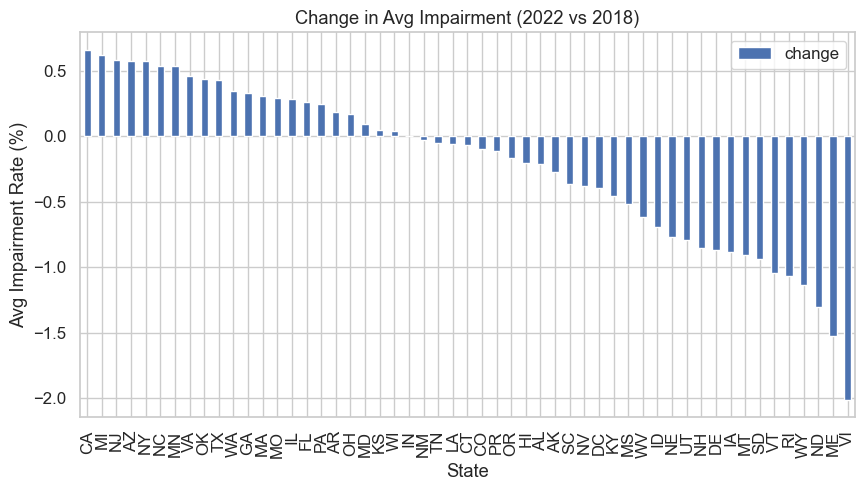

In [97]:
trend = (
    pl.concat([
        df_2018_state.with_columns(pl.lit(2018).alias("year")),
        df_2022_state.with_columns(pl.lit(2022).alias("year"))
    ])
    .group_by(["year", "locationabbr"])
    .agg(pl.col("data_value").mean().alias("avg_data_value"))
    .sort(["locationabbr", "year"])
)

wide = (
    trend
    .pivot(index="locationabbr", columns="year", values="avg_data_value")
    .with_columns((pl.col("2022") - pl.col("2018")).alias("change"))
    .sort("change", descending=True)
)

wide_df = wide.to_pandas()

wide_df.sort_values("change", ascending=False).plot(
    kind="bar", x="locationabbr", y="change", figsize=(10,5)
)
plt.title("Change in Avg Impairment (2022 vs 2018)")
plt.xlabel("State")
plt.ylabel("Avg Impairment Rate (%)")
plt.show()

In [62]:
fig = px.choropleth(
    wide_df,
    locations="locationabbr",
    locationmode="USA-states",
    color="change",
    color_continuous_scale="RdBu",
    title="Change in Average Impairment Rate (2018 to 2022)",
    scope="usa"
)
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



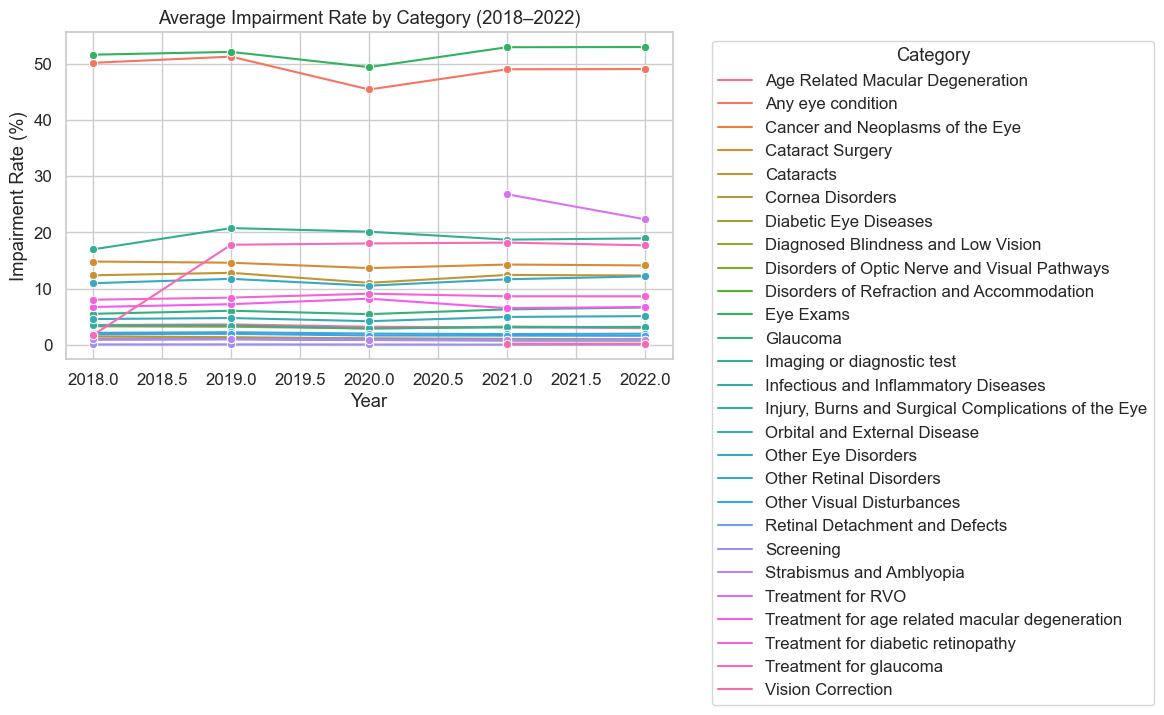

In [94]:
df_all = pl.concat([df_2018_state, df_2019_state, df_2020_state, df_2021_state, df_2022_state])

trend_by_category = (
    df_all
    .filter(pl.col("geographiclevel") == "State")
    .group_by(["yearstart", "category"])
    .agg(pl.col("data_value").mean().alias("avg_value"))
    .sort(["category", "yearstart"])
    .to_pandas()
)


plt.figure(figsize=(12,6))
sb.lineplot(data=trend_by_category, x="yearstart", y="avg_value", hue="category", marker="o")
plt.title("Average Impairment Rate by Category (2018–2022)")
plt.xlabel("Year")
plt.ylabel("Impairment Rate (%)")

# Move legend outside
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Make room for the legend
plt.show()

In [101]:
# Pivot so categories are rows and years are columns
category_table = trend_by_category.pivot(
    index='category',
    columns='yearstart',
    values='avg_value'
)

# Optional: sort by one of the years
category_table = category_table.sort_values(by=2018, ascending=False)

category_table['Change (2018→2022)'] = category_table[2022] - category_table[2018]

category_table = category_table.round(2)

category_table

yearstart,2018,2019,2020,2021,2022,Change (2018→2022)
category,,,,,,
Eye Exams,51.66,52.16,49.44,52.99,53.02,1.36
Any eye condition,50.21,51.31,45.46,49.06,49.10,-1.11
Imaging or diagnostic test,16.99,20.78,20.14,18.72,18.95,1.95
Cataract Surgery,14.83,14.61,13.65,14.29,14.13,-0.70
Cataracts,12.38,12.81,11.03,12.44,12.34,-0.03
Other Eye Disorders,10.96,11.74,10.52,11.66,12.18,1.22
Treatment for diabetic retinopathy,8.02,8.40,9.09,8.63,8.63,0.61
Treatment for age related macular degeneration,6.73,7.23,8.21,6.52,6.72,-0.01
Glaucoma,5.52,6.06,5.46,6.30,6.65,1.13


In [51]:
cat_summary = (
    df_all
    .group_by("category")
    .agg(pl.mean("data_value").alias("avg_impairment"))
    .sort("avg_impairment", descending=True)
)
cat_summary.head(10)

category,avg_impairment
str,f64
"""Eye Exams""",52.369494
"""Any eye condition""",49.315497
"""Treatment for RVO""",24.340837
"""Imaging or diagnostic test""",18.988104
"""Treatment for glaucoma""",16.459812
"""Cataract Surgery""",14.330464
"""Cataracts""",12.343382
"""Other Eye Disorders""",11.622826
"""Treatment for diabetic retinop…",8.528901


In [69]:
race_summary = (
    df_all
    .group_by("raceethnicity")
    .agg(pl.mean("data_value").alias("avg_impairment"))
    .sort("avg_impairment", descending=True)
)
race_year_summary = (
    df_all
    .group_by(["yearstart", "raceethnicity"])
    .agg(pl.mean("data_value").alias("avg_impairment"))
    .sort(["raceethnicity","yearstart"])
)

In [78]:
# Recompute summary (includes 2021 now)
race_year_summary = (
    df_all
    .group_by(["yearstart", "raceethnicity"])
    .agg(pl.mean("data_value").alias("avg_impairment"))
    .sort(["raceethnicity", "yearstart"])
)

# Convert to pandas for pivoting
race_year_summary_df = race_year_summary.to_pandas().round(3)

# Pivot: races as rows, years as columns
race_year_pivot = race_year_summary_df.pivot(
    index="raceethnicity",
    columns="yearstart",
    values="avg_impairment"
).round(3)

# Ensure columns are ints and sorted chronologically
race_year_pivot.columns = race_year_pivot.columns.astype(int)
race_year_pivot = race_year_pivot.reindex(sorted(race_year_pivot.columns), axis=1)

# Add a "Change (2018→2022)" column
if all(y in race_year_pivot.columns for y in [2018, 2022]):
    race_year_pivot["Change (2018→2022)"] = race_year_pivot[2022] - race_year_pivot[2018]
else:
    print("⚠️ Warning: Either 2018 or 2022 not present in your data; skipping change column.")

# Add total row
totals = race_year_pivot.sum(numeric_only=True, axis=0).rename("Total (All Races)")
race_year_pivot.loc["Total (All Races)"] = totals

# Sort by most recent year (or by change column if present)
sort_col = "Change (2018→2022)" if "Change (2018→2022)" in race_year_pivot.columns else race_year_pivot.columns.max()
race_year_pivot = race_year_pivot.sort_values(by=sort_col, ascending=False)

# Round final table
race_year_pivot = race_year_pivot.round(2)

# Display
race_year_pivot


yearstart,2018,2019,2020,2021,2022,Change (2018→2022)
raceethnicity,,,,,,
All races,8.71,9.70,9.20,9.92,9.31,0.60
"Black, non-Hispanic",9.00,10.25,9.64,9.80,9.20,0.20
"White, non-Hispanic",9.23,10.08,9.59,9.98,9.38,0.16
"Hispanic, any race",10.09,11.02,10.37,9.93,9.26,-0.83
Asian,10.70,11.69,10.70,9.77,9.18,-1.53
North American Native,9.19,9.90,9.13,7.92,7.37,-1.82
Other,11.31,12.48,11.52,10.07,9.46,-1.85
Total (All Races),68.23,75.10,70.14,67.38,63.16,-5.07


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



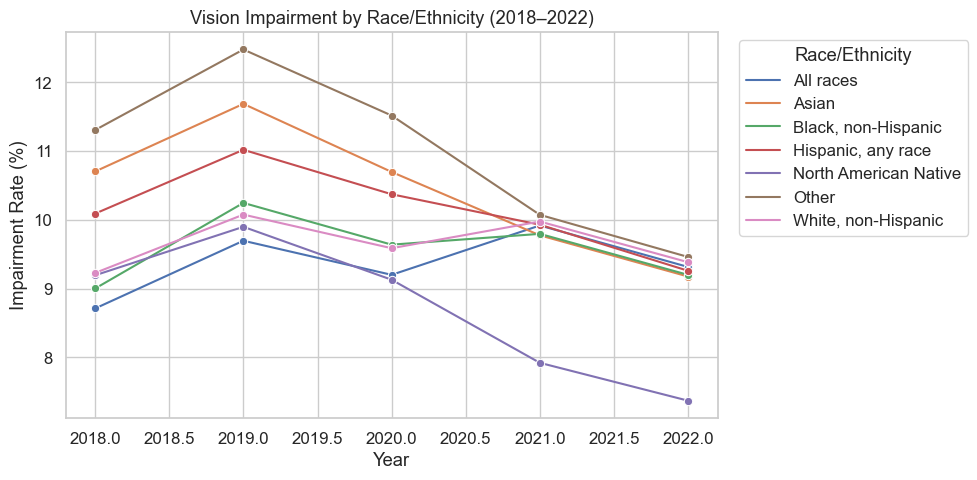

In [93]:
race_year_pd = race_year_summary.to_pandas()

plt.figure(figsize=(10,5))
sb.lineplot(
    data=race_year_pd, x="yearstart", y="avg_impairment",
    hue="raceethnicity", marker="o"
)
plt.title("Vision Impairment by Race/Ethnicity (2018–2022)")
plt.xlabel("Year")
plt.ylabel("Impairment Rate (%)")
plt.legend(title="Race/Ethnicity", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

,locationabbr,avg_impairment,yearstart,rank
0,HI,11.044,2018,1
1,DE,10.494,2018,2
2,VI,10.442,2018,3
3,RI,10.423,2018,4
4,DC,10.391,2018,5
5,HI,12.424,2019,1
6,VI,12.142,2019,2
7,DC,11.749,2019,3
8,DE,11.130,2019,4
9,RI,11.105,2019,5


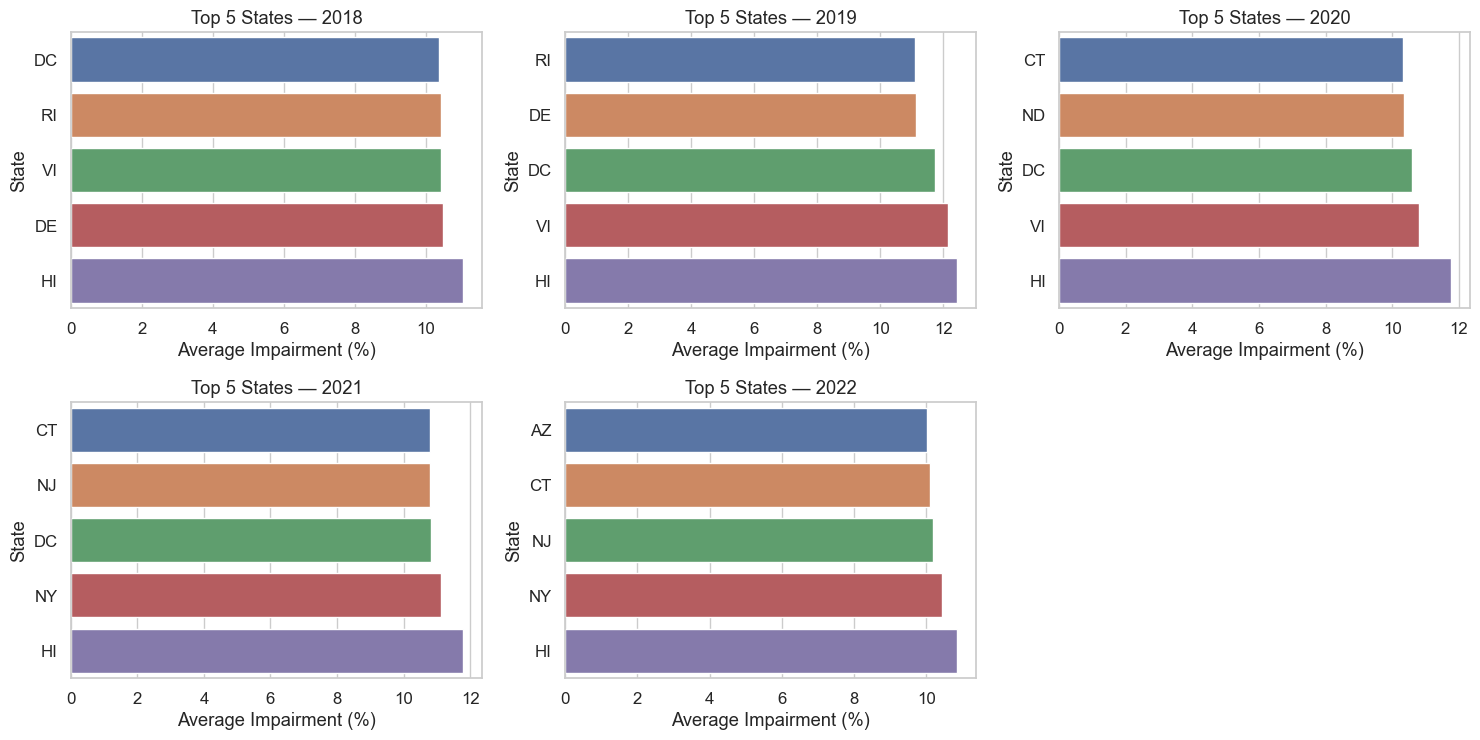

In [92]:
years = sorted(pl.Series(df_all.select("yearstart").to_series()).unique().to_list())

# 2) Compute top-5 states per year in Polars, then concat
tops = []
for y in years:
    top = (
        df_all
        .filter(pl.col("yearstart") == y)
        .group_by("locationabbr")
        .agg(pl.mean("data_value").alias("avg_impairment"))
        .sort("avg_impairment", descending=True)
        .head(5)
        .with_columns(pl.lit(y).alias("yearstart"))
    )
    tops.append(top)

top5_states = pl.concat(tops).to_pandas()

# 3) Add rank (1=highest) within each year for a clean table
top5_states["rank"] = (
    top5_states.groupby("yearstart")["avg_impairment"]
    .rank(method="first", ascending=False)
    .astype(int)
)

# 4) Make a tidy table sorted by year then rank
top5_table = (
    top5_states
    .sort_values(["yearstart", "rank"])
    .reset_index(drop=True)
)

# Optional: round for display and save to CSV for Overleaf
top5_table["avg_impairment"] = top5_table["avg_impairment"].round(3)
display(top5_table)  # shows in notebook


# 5) Plot small multiples: Top-5 states per year
n_years = len(years)
ncols = min(3, n_years)
nrows = (n_years + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows), squeeze=False)
for ax, y in zip(axes.ravel(), years):
    d = top5_states[top5_states["yearstart"] == y].sort_values("avg_impairment", ascending=True)
    sb.barplot(data=d, x="avg_impairment", y="locationabbr", ax=ax)
    ax.set_title(f"Top 5 States — {y}")
    ax.set_xlabel("Average Impairment (%)")
    ax.set_ylabel("State")
for ax in axes.ravel()[len(years):]:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [63]:
# Get unique years (sorted)
years = sorted(df_all.select("yearstart").unique().to_series().to_list())

# Loop through years and generate maps
for year_sel in years:
    # Aggregate by state for the given year
    state_year_pd = (
        df_all
        .filter(pl.col("yearstart") == year_sel)
        .group_by("locationabbr")
        .agg(pl.mean("data_value").alias("avg_impairment"))
        .to_pandas()
    )

    # Skip if missing or incomplete data
    if state_year_pd.empty or state_year_pd["avg_impairment"].isna().all():
        print(f"Skipping {year_sel} (no data).")
        continue

    # Create choropleth map
    fig = px.choropleth(
        state_year_pd,
        locations="locationabbr",
        locationmode="USA-states",
        color="avg_impairment",
        scope="usa",
        color_continuous_scale="Reds",
        title=f"Vision Impairment by State ({year_sel})",
        labels={"avg_impairment": "Avg Impairment Rate"}
    )

    # Optional: make it visually consistent
    fig.update_layout(
        title_x=0.5,
        geo=dict(showlakes=True, lakecolor="lightblue"),
        coloraxis_colorbar=dict(title="Impairment (%)")
    )

    fig.show()

# # Optional: save for Overleaf
# fig.write_image(f"/content/vision_impairment_map_{year_sel}.pdf")

In [87]:
# --- Inspect and prepare risk factor variables ---

# 1️⃣ Get unique values and counts
risk_vals = df_all.get_column("riskfactor").unique().to_list()
riskresp_vals = df_all.get_column("riskfactorresponse").unique().to_list()
risk_n = df_all.select(pl.col("riskfactor").n_unique()).item()
riskresp_n = df_all.select(pl.col("riskfactorresponse").n_unique()).item()

print(f"Unique riskfactor values ({risk_n}):", risk_vals[:10])
print(f"Unique riskfactorresponse values ({riskresp_n}):", riskresp_vals[:10])

# 2️⃣ Drop if they have only one constant value
if risk_n == 1:
    print("Dropping 'riskfactor' — only one unique value.")
    df_all = df_all.drop("riskfactor")

if riskresp_n == 1:
    print("Dropping 'riskfactorresponse' — only one unique value.")
    df_all = df_all.drop("riskfactorresponse")

# 3️⃣ If multiple categories exist, clean and split patterns like "Diabetes: Yes"
if "riskfactor" in df_all.columns:
    df_all = df_all.with_columns([
        pl.when(pl.col("riskfactor").str.contains(":"))
          .then(pl.col("riskfactor").str.split_exact(": ", 1).struct.field("field_0"))
          .otherwise(pl.col("riskfactor"))
          .alias("riskfactor_clean"),
        pl.when(pl.col("riskfactor").str.contains(":"))
          .then(pl.col("riskfactor").str.split_exact(": ", 1).struct.field("field_1"))
          .otherwise(pl.lit("Total"))
          .alias("risk_level")
    ])

# 4️⃣ Summarize impairment by risk factor / level over time
if "riskfactor_clean" in df_all.columns:
    risk_summary = (
        df_all
        .filter(pl.col("riskfactor_clean").is_not_null())
        .group_by(["yearstart", "riskfactor_clean", "risk_level"])
        .agg(pl.mean("data_value").alias("avg_impairment"))
        .sort(["riskfactor_clean", "risk_level", "yearstart"])
    )
    print(risk_summary.head(10))


Unique riskfactor values (18): ['Hypertension and glaucoma', 'Diabetes', 'Age-related macular degeneration', 'Any retinal vein occlusion', 'Glaucoma', 'Diabetes and diabetic retinopathy', 'Diabetic retinopathy', 'Diabetes and glaucoma', 'Hypertension and AMD', 'Diabetes and RVO']
Unique riskfactorresponse values (2): ['Yes', 'Total']
shape: (10, 4)
┌───────────┬─────────────────────────────────┬────────────┬────────────────┐
│ yearstart ┆ riskfactor_clean                ┆ risk_level ┆ avg_impairment │
│ ---       ┆ ---                             ┆ ---        ┆ ---            │
│ i64       ┆ str                             ┆ str        ┆ f64            │
╞═══════════╪═════════════════════════════════╪════════════╪════════════════╡
│ 2018      ┆ Age-related macular degenerati… ┆ Total      ┆ 25.580408      │
│ 2019      ┆ Age-related macular degenerati… ┆ Total      ┆ 27.347124      │
│ 2020      ┆ Age-related macular degenerati… ┆ Total      ┆ 27.368657      │
│ 2021      ┆ Age-related

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

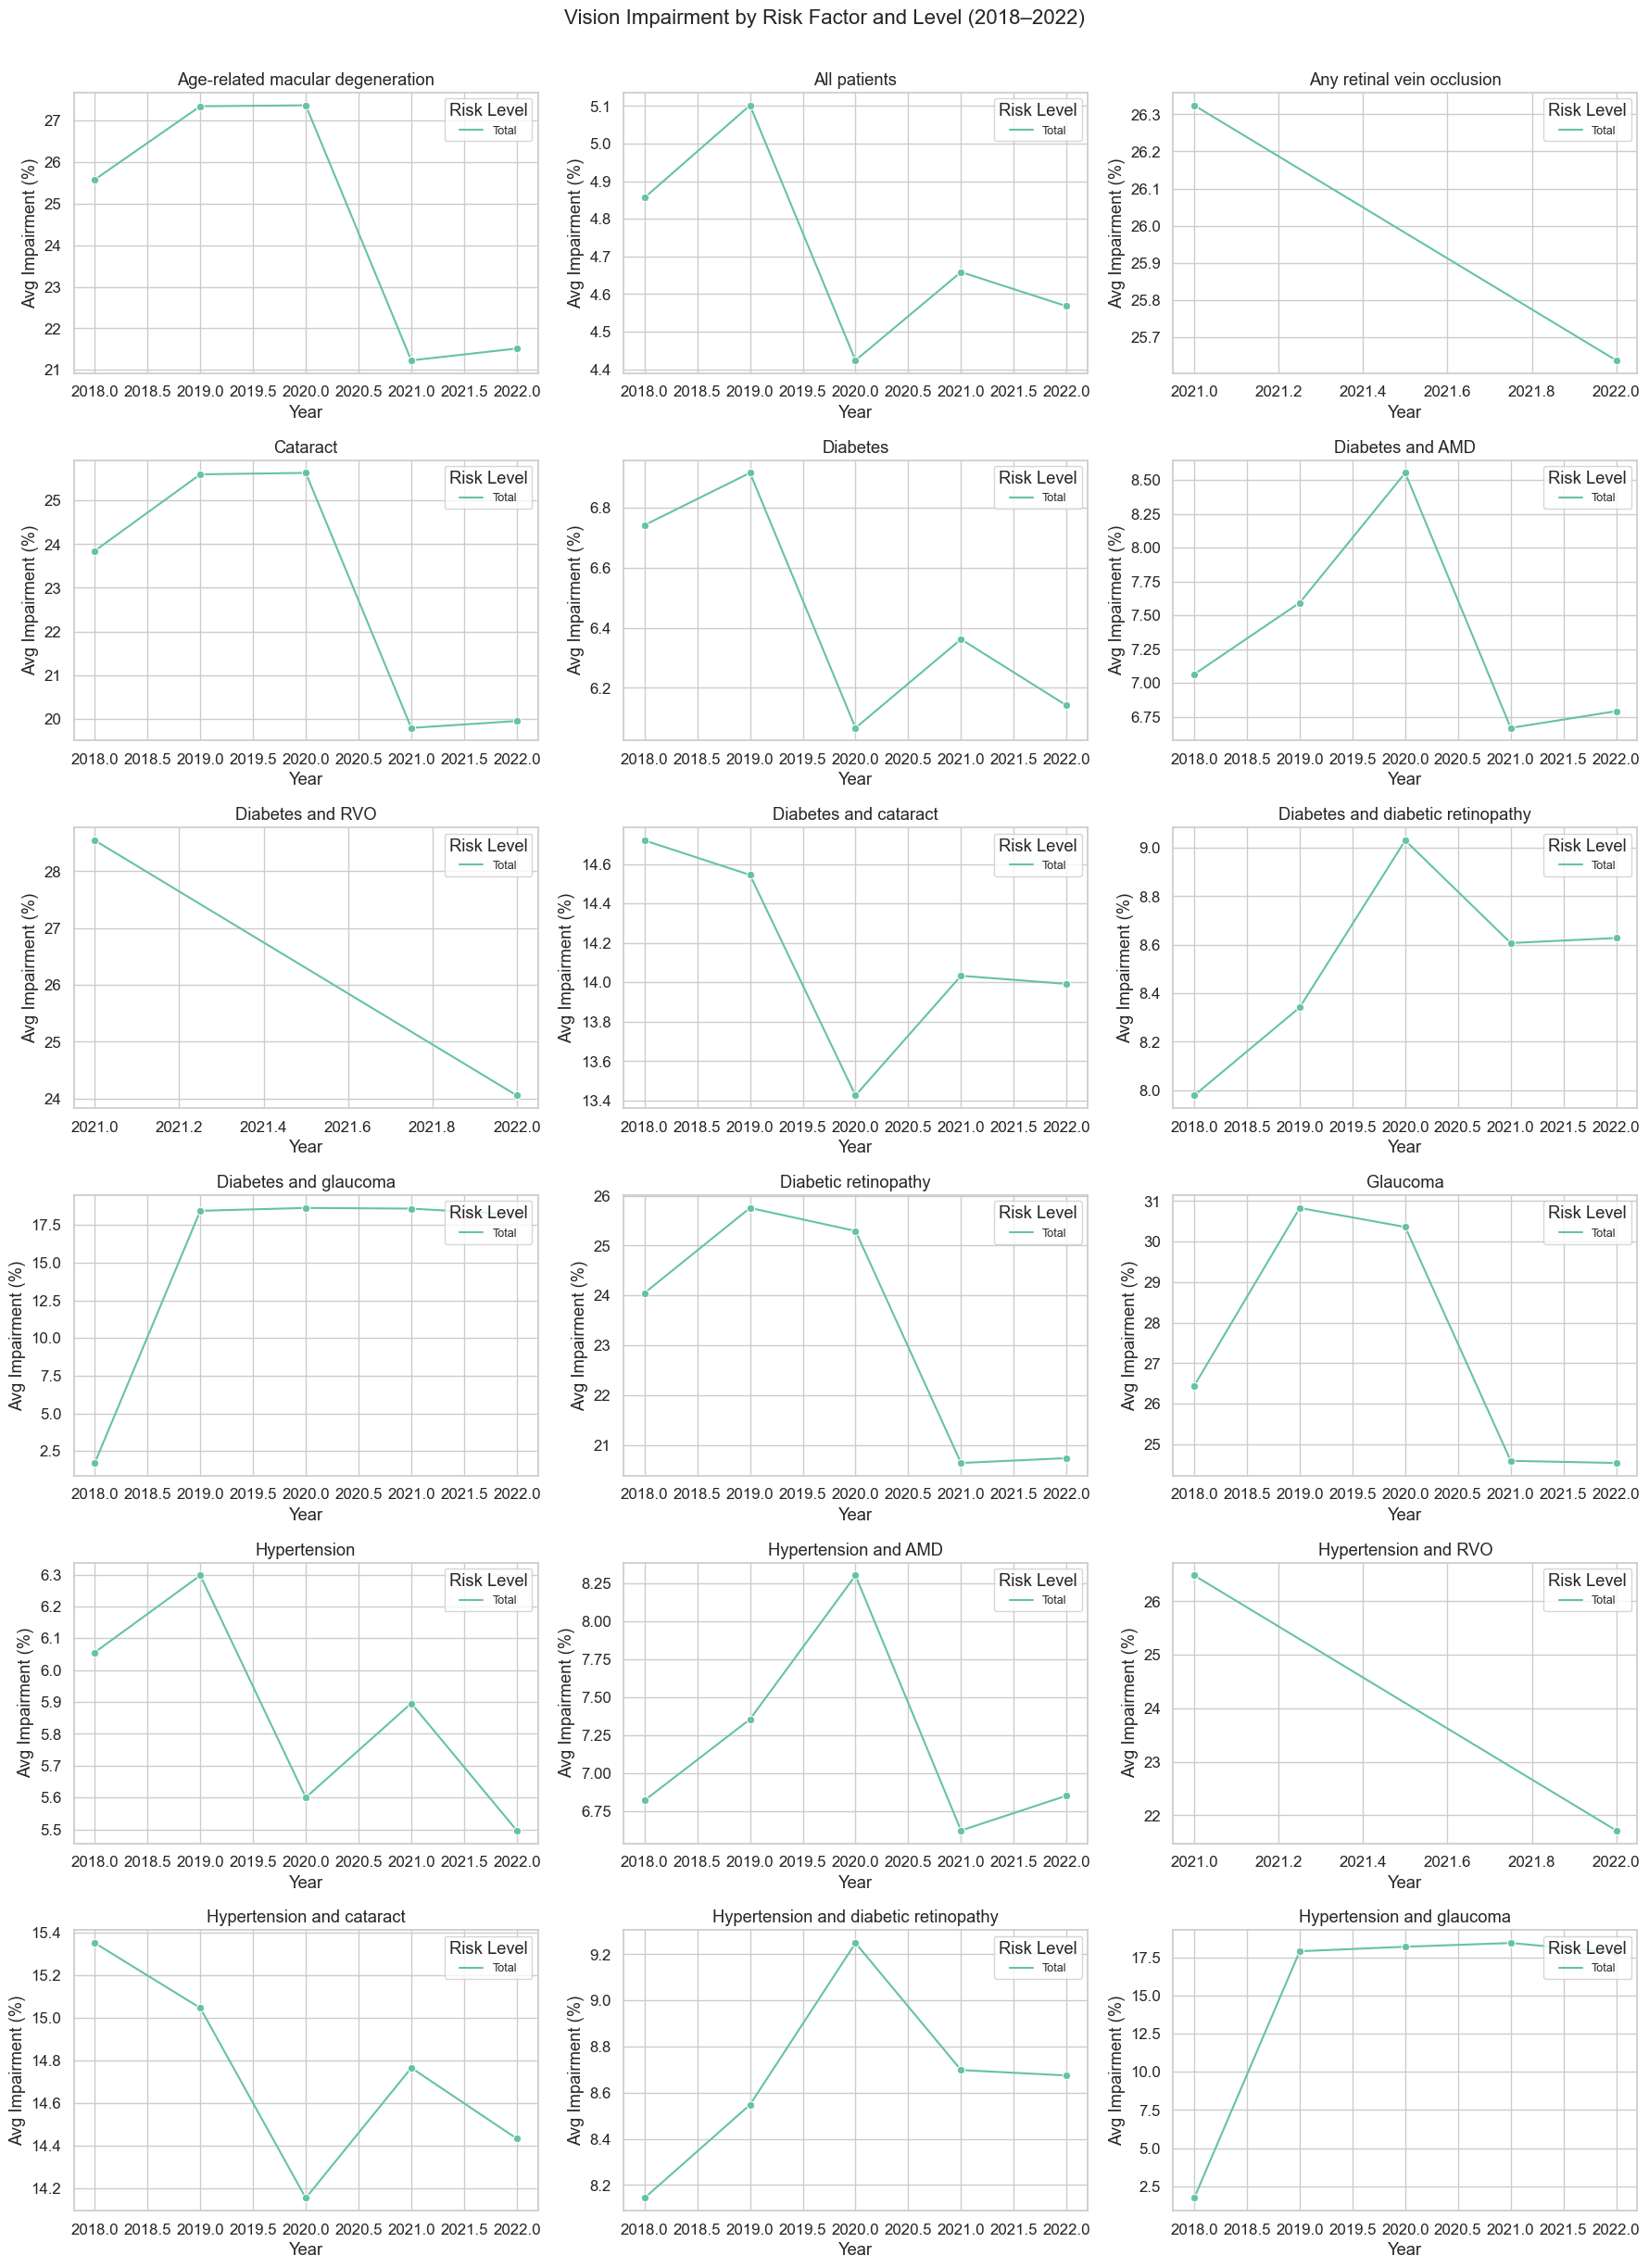

In [88]:

# Convert to pandas for plotting
risk_df = risk_summary.to_pandas()

# List unique risk factors
risk_factors = sorted(risk_df["riskfactor_clean"].unique())

# Choose how many plots per row
cols = 3
rows = math.ceil(len(risk_factors) / cols)

plt.figure(figsize=(6 * cols, 4 * rows))
sb.set(style="whitegrid", font_scale=1.1)

for i, rf in enumerate(risk_factors, 1):
    plt.subplot(rows, cols, i)
    subset = risk_df[risk_df["riskfactor_clean"] == rf]
    sb.lineplot(
        data=subset,
        x="yearstart",
        y="avg_impairment",
        hue="risk_level",
        marker="o",
        palette="Set2",
    )
    plt.title(rf)
    plt.xlabel("Year")
    plt.ylabel("Avg Impairment (%)")
    plt.legend(title="Risk Level", loc="upper right", fontsize=9)
    plt.tight_layout()

plt.suptitle("Vision Impairment by Risk Factor and Level (2018–2022)", fontsize=16, y=1.02)
plt.show()

In [71]:
sb.set(style="whitegrid", font_scale=1.1)
YEARS_ORDER = [2018, 2019, 2020, 2021, 2022]
USE_WEIGHTED = False  # set True to weight means by sample_size if available/clean

# -- Ensure numeric columns are numeric (handles commas/strings) --
def _clean_numeric(df: pl.DataFrame, cols):
    out = df
    for c in cols:
        if c in out.columns:
            if out.schema[c] == pl.Utf8:
                out = out.with_columns(pl.col(c).str.replace_all(",", "").cast(pl.Float64, strict=False))
            else:
                out = out.with_columns(pl.col(c).cast(pl.Float64, strict=False))
    return out

df_all = _clean_numeric(df_all, ["data_value", "sample_size"])

# -- Filter to consistent geography (State) and non-null data_value --
base = (
    df_all
    .filter(pl.col("geographiclevel") == "State")
    .filter(pl.col("data_value").is_not_null())
)

# -- Helper: groupby-mean (weighted or not) --
def group_mean(frame: pl.DataFrame, by):
    if USE_WEIGHTED and "sample_size" in frame.columns:
        return (
            frame
            .with_columns((pl.col("data_value") * pl.col("sample_size")).alias("w_val"))
            .group_by(by)
            .agg((pl.sum("w_val") / pl.sum("sample_size")).alias("avg_value"))
        )
    else:
        return frame.group_by(by).agg(pl.mean("data_value").alias("avg_value"))


Year,2018,2019,2020,2021,2022,Change (2018→2022)
Age Group,,,,,,
0-17 years,0.06,0.08,0.03,0.01,0.03,-0.03
18-39 years,6.37,6.99,6.59,3.43,3.02,-3.35
40-64 years,7.74,8.60,8.33,7.32,6.69,-1.05
65-84 years,9.32,10.18,9.65,10.78,10.14,0.82
85 years and older,10.86,11.89,11.14,10.37,9.85,-1.00
Total (All Ages),6.87,7.55,7.15,6.38,5.95,-0.92


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



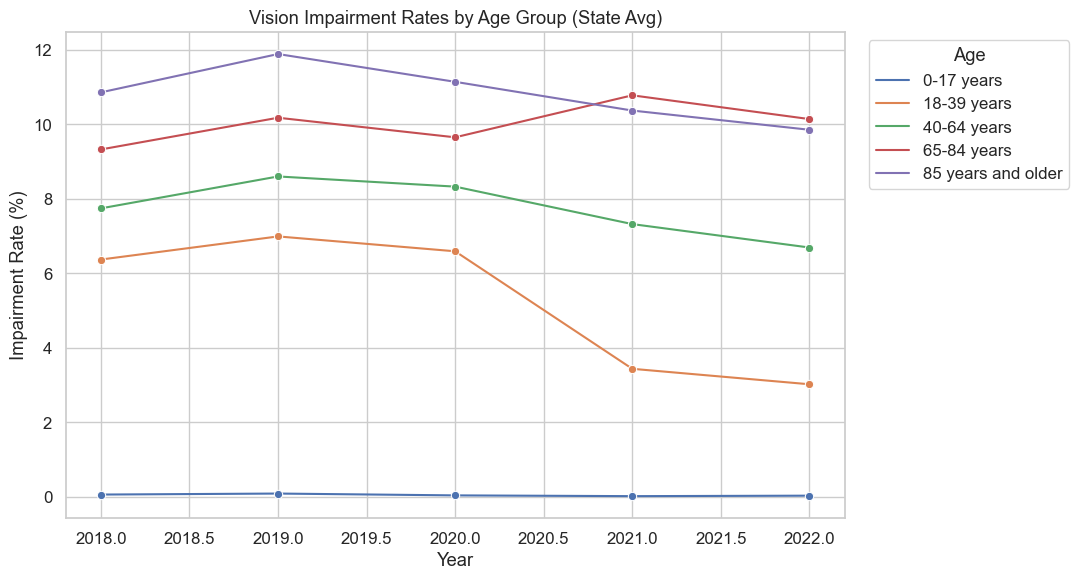

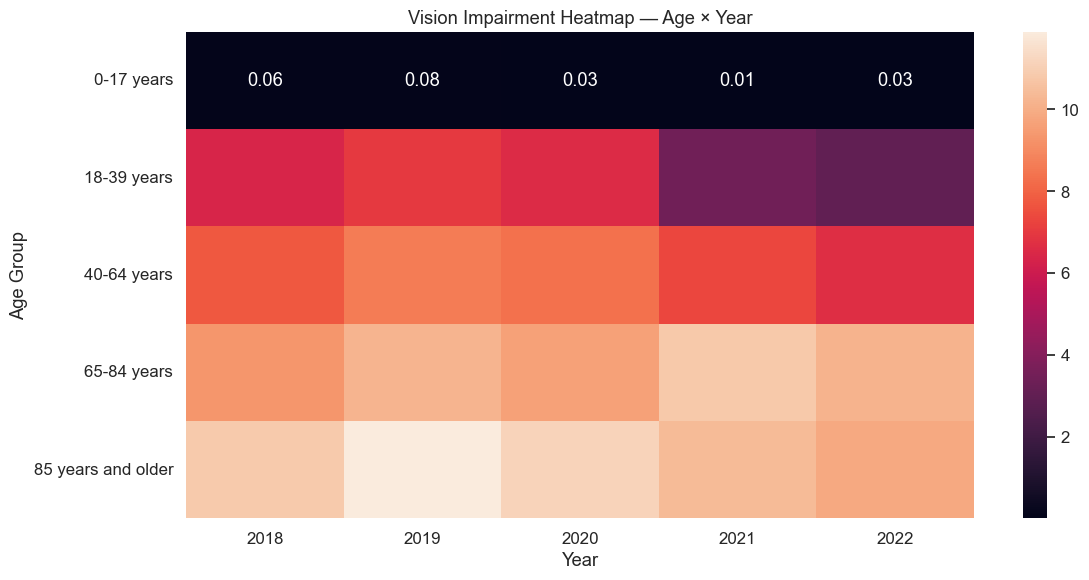

In [90]:
# ========= AGE (cleaned: remove umbrella labels, keep non-overlapping ranges) =========
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.1)

# 0) Define which labels to drop (overlapping/aggregate bins)
redundant_labels = [
    "All ages",
    "Total (All Ages)",
    "18 years and older",
    "40 years and older",
    "65 years and older"
]

# 1) Compute averages by age after removing redundant labels
age_year = (
    base
    .filter(~pl.col("age").is_in(redundant_labels))                 # drop umbrella categories
    .pipe(group_mean, ["yearstart", "age"])                         # your helper (weighted or unweighted)
    .sort(["age", "yearstart"])
    .to_pandas()
)

# 2) Order age groups logically (only those present will be used)
desired_age_order = [
    "0-17 years",
    "18-39 years",
    "40-64 years",
    "65-84 years",
    "85 years and older",
]
present_ages = [a for a in desired_age_order if a in age_year["age"].unique()]
# If some labels are unexpected, append them at the end in alphabetical order:
others = sorted([a for a in age_year["age"].unique() if a not in present_ages])
age_order = present_ages + others

age_year["age"] = pd.Categorical(age_year["age"], categories=age_order, ordered=True)
age_year = age_year.sort_values(["age", "yearstart"])

# 3) Pivot: Age x Year
age_pivot = (
    age_year
    .pivot(index="age", columns="yearstart", values="avg_value")
    .rename_axis(index="Age Group", columns="Year")
)

# 4) Order year columns if present
present_years = [y for y in YEARS_ORDER if y in age_pivot.columns]
age_pivot = age_pivot.reindex(columns=present_years)

# 5) Add Total row (mean across ages per year) — optional for a quick sanity check
age_pivot.loc["Total (All Ages)"] = age_pivot.mean(axis=0, numeric_only=True)

# 6) Add Change 2018→2022 if both exist
if 2018 in age_pivot.columns and 2022 in age_pivot.columns:
    age_pivot["Change (2018→2022)"] = (age_pivot[2022] - age_pivot[2018])

# 7) Round and display
age_pivot = age_pivot.round(2)
display(age_pivot)

# --------- Plots using CLEANED data ---------

# Plot 1: Trend lines by Age (cleaned)
plt.figure(figsize=(11,6))
sns.lineplot(data=age_year, x="yearstart", y="avg_value", hue="age", marker="o")
plt.title("Vision Impairment Rates by Age Group (State Avg)")
plt.xlabel("Year"); plt.ylabel("Impairment Rate (%)")
plt.legend(title="Age", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# Plot 2: Heatmap Age x Year (cleaned)
plt.figure(figsize=(12,6))
sns.heatmap(
    age_pivot.drop(index="Total (All Ages)", errors="ignore")
             .drop(columns=["Change (2018→2022)"], errors="ignore"),
    annot=True, fmt=".2f", cbar=True
)
plt.title("Vision Impairment Heatmap — Age × Year")
plt.xlabel("Year"); plt.ylabel("Age Group")
plt.tight_layout(); plt.show()


Year,2018,2019,2020,2021,2022,Change (2018→2022)
Sex,,,,,,
Female,9.62,10.53,9.88,9.97,9.38,-0.24
Male,8.99,9.87,9.34,9.37,8.76,-0.23
Total (All Sex),9.30,10.20,9.61,9.67,9.07,-0.23


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



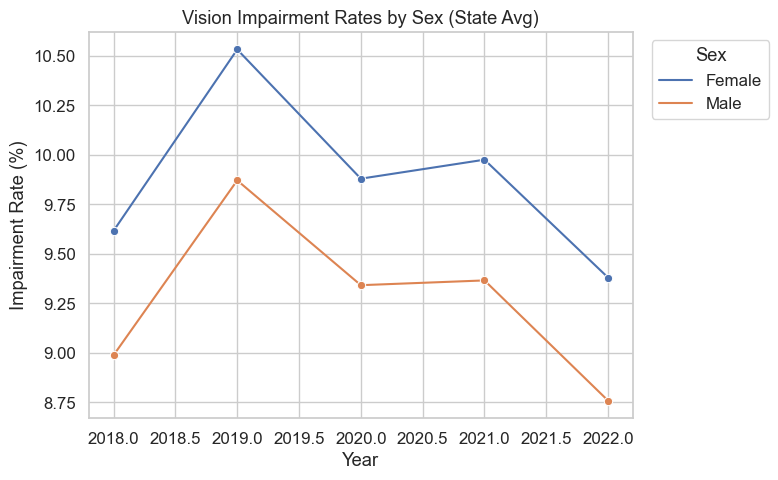

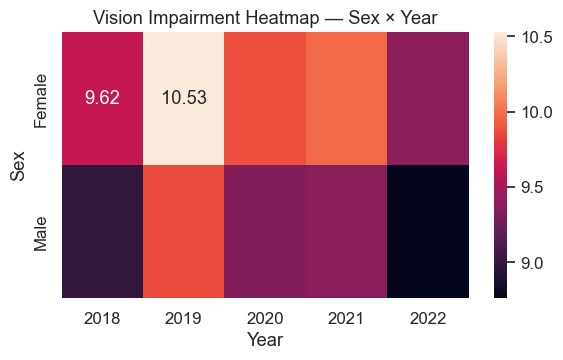

In [91]:
# ========= SEX (cleaned: remove umbrella labels, keep non-overlapping groups) =========
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.1)

# 0) Define which labels to drop (overlapping/aggregate bins)
sex_redundant_labels = [
    "Both sexes",
    "All sexes",
    "Total (All Sex)",    # in case it exists
    "All"                 # safety catch for odd labels
]

# 1) Compute averages by sex after removing redundant labels
sex_year = (
    base
    .filter(~pl.col("sex").is_in(sex_redundant_labels))      # drop umbrella categories
    .pipe(group_mean, ["yearstart", "sex"])                  # your helper (weighted or unweighted)
    .sort(["sex", "yearstart"])
    .to_pandas()
)

# 2) Order sex groups logically (only those present will be used)
desired_sex_order = ["Female", "Male"]
present_sex = [s for s in desired_sex_order if s in sex_year["sex"].unique()]
# If unexpected labels are present (e.g., "Unknown", "Other"), append them alphabetically
other_sex = sorted([s for s in sex_year["sex"].unique() if s not in present_sex])
sex_order = present_sex 

sex_year["sex"] = pd.Categorical(sex_year["sex"], categories=sex_order, ordered=True)
sex_year = sex_year.sort_values(["sex", "yearstart"])

# 3) Pivot: Sex x Year
sex_pivot = (
    sex_year
    .pivot(index="sex", columns="yearstart", values="avg_value")
    .rename_axis(index="Sex", columns="Year")
)

# 4) Order year columns if present
present_years = [y for y in YEARS_ORDER if y in sex_pivot.columns]
sex_pivot = sex_pivot.reindex(columns=present_years)

# 5) Add Total row (mean across sex per year) — sanity check
sex_pivot.loc["Total (All Sex)"] = sex_pivot.mean(axis=0, numeric_only=True)

# 6) Add Change 2018→2022 if both exist
if 2018 in sex_pivot.columns and 2022 in sex_pivot.columns:
    sex_pivot["Change (2018→2022)"] = sex_pivot[2022] - sex_pivot[2018]

# 7) Round and display
sex_pivot = sex_pivot.round(2)
display(sex_pivot)

# --------- Plots using CLEANED data ---------

# Plot 1: Trend lines by Sex (cleaned)
plt.figure(figsize=(8,5))
sns.lineplot(data=sex_year, x="yearstart", y="avg_value", hue="sex", marker="o")
plt.title("Vision Impairment Rates by Sex (State Avg)")
plt.xlabel("Year"); plt.ylabel("Impairment Rate (%)")
plt.legend(title="Sex", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# Plot 2: (Optional) Heatmap Sex x Year — small but useful for reports
plt.figure(figsize=(6,3.8))
sns.heatmap(
    sex_pivot.drop(index="Total (All Sex)", errors="ignore")
            .drop(columns=["Change (2018→2022)"], errors="ignore"),
    annot=True, fmt=".2f", cbar=True
)
plt.title("Vision Impairment Heatmap — Sex × Year")
plt.xlabel("Year"); plt.ylabel("Sex")
plt.tight_layout(); plt.show()

# ----- Optional: Export table for Overleaf -----
# print(sex_pivot.to_latex(index=True, caption="Average Vision Impairment by Sex (2018–2022)",
#                          label="tab:imp_by_sex", na_rep="--", column_format="lccccc"))
# sex_pivot.to_csv("/content/impairment_by_sex.csv", index=True)

In [102]:
# === EXPORT ALL PIVOTS / TABLES TO CSV ===
# Export Race pivot

output_dir = Path("/Users/anviththumma/Desktop/School/DAT 490/tables/")

race_year_pivot.to_csv(output_dir / "race_year_pivot.csv", index=True)
print("✅ Saved race_year_pivot.csv")

# Export Age pivot
age_pivot.to_csv(output_dir / "age_pivot.csv", index=True)
print("✅ Saved age_pivot.csv")

# Export Sex pivot
sex_pivot.to_csv(output_dir / "sex_pivot.csv", index=True)
print("✅ Saved sex_pivot.csv")

# Export Category pivot (if applicable)
try:
    category_table.to_csv(output_dir / "category_table.csv", index=True)
    print("✅ Saved category_table.csv")
except NameError:
    print("ℹ️ category_table not found — skipped")

# Export Risk Factor pivot (if applicable)
try:
    risk_summary_df = risk_summary.to_pandas().round(3)
    risk_summary_df.to_csv(output_dir / "risk_summary.csv", index=False)
    print("✅ Saved risk_summary.csv")
except NameError:
    print("ℹ️ risk_summary not found — skipped")


✅ Saved race_year_pivot.csv
✅ Saved age_pivot.csv
✅ Saved sex_pivot.csv
✅ Saved category_table.csv
✅ Saved risk_summary.csv
